# Evaluating the Neural Network

`data.py` file

In [54]:
import numpy as np
import pydicom as dicom
import random
import os
from glob import glob
import scipy.ndimage
import re
import sys
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images

def natural_sort(l): 
    convert = lambda text: int(text) if text.isdigit() else text.lower() 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)

def load_scan(path):
    #slices = [dicom.read_file((path + '/' + s) for s in os.listdir(path))]
    slices = []
    for file in glob(path + '/*.DCM'):
        slices.append(dicom.read_file(file))
    slices.sort(key = lambda x: int(x.InstanceNumber)) # sort by slice number
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

def show_dcm_info(dataset, path):
    print("Filename.........:", path)
    print("Storage type.....:", dataset.SOPClassUID)
    print()

    pat_name = dataset.PatientName
    display_name = pat_name.family_name + ", " + pat_name.given_name
    print("Patient's name......:", display_name)
    print("Patient id..........:", dataset.PatientID)
    print("Patient's Age.......:", dataset.PatientAge)
    print("Patient's Sex.......:", dataset.PatientSex)
    print("Modality............:", dataset.Modality)
    print("Body Part Examined..:", dataset.BodyPartExamined)
    if 'ViewPosition' in dataset:
        print("View Position.......:", dataset.ViewPosition)
    
    if 'PixelData' in dataset:
        rows = int(dataset.Rows)
        cols = int(dataset.Columns)
        print("Image size.......: {rows:d} x {cols:d}, {size:d} bytes".format(
            rows=rows, cols=cols, size=len(dataset.PixelData)))
        if 'PixelSpacing' in dataset:
            print("Pixel spacing....:", dataset.PixelSpacing)

def get_pixels(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)
    
    return np.array(image, dtype=np.int16)

def sample_stack(stack, rows=4, cols=5, start_with=0, show_every=1):
    fig,ax = plt.subplots(rows,cols,figsize=[12,12])
    ind = start_with
    for i in range(rows):
        for j in range(cols):
            ax[i,j].set_title('slice %d' % (ind+1))
            ax[i,j].imshow(stack[ind],cmap='gray')
            ax[i,j].axis('off')
            ind = ind + show_every
    plt.show()

def get_data(TRAIN_PATH,TEST_PATH,IMG_WIDTH,IMG_HEIGHT,NUM_SLICES,IMG_CHANNELS):
    # Get train and test IDs
    train_ids = next(os.walk(TRAIN_PATH+'imgs/'))[2]
    test_ids = next(os.walk(TEST_PATH+'imgs/'))[2]

    # Get and resize train images and masks
    #print('Getting train images and masks ... ')
    X_train = np.zeros((len(train_ids)*NUM_SLICES, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint16)
    y_train = np.zeros((len(train_ids)*NUM_SLICES, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
        i = 0
        path = TRAIN_PATH + 'imgs/' + id_
        img = np.load(path)[:,:,:,np.newaxis]
        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
        maskpath = TRAIN_PATH + 'labels/' + id_
        mask_ = np.load(maskpath)[:,:,:,np.newaxis]
        mask = np.maximum(mask, mask_)
        for i in range(NUM_SLICES):
            X_train[n*NUM_SLICES + i] = img[i]
            y_train[n*NUM_SLICES + i] = mask[i]
            i+=1

    # Get and resize test images
    #print('Getting test images and masks ... ')
    X_test = np.zeros((len(test_ids)*NUM_SLICES, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint16)
    y_test = np.zeros((len(test_ids)*NUM_SLICES, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    sizes_test = []
    for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
        i = 0
        path = TEST_PATH + 'imgs/' + id_
        img = np.load(path)[:,:,:,np.newaxis]
        sizes_test.append([img.shape[0], img.shape[1]])
        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
        maskpath = TEST_PATH + 'labels/' + id_
        mask_ = np.load(maskpath)[:,:,:,np.newaxis]
        mask = np.maximum(mask, mask_)
        for i in range(NUM_SLICES):
            X_test[n*NUM_SLICES + i] = img[i]
            y_test[n*NUM_SLICES + i] = mask[i]
            i+=1
    print('Done!')

    return (X_train, X_test, y_train, y_test)

`model.py` file

In [2]:
from keras.models import Model, load_model, model_from_json
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

# define metrics

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Build U-Net model
def unet(width, height, channels, pretrained_weights = None):
    inputs = Input((width, height, channels))
    s = Lambda(lambda x: x / 255) (inputs) 

    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (s)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer=Adam(lr = 1e-4), loss='binary_crossentropy', metrics=[dice_coef,'accuracy'])
    if(pretrained_weights):
        model.load_weights(pretrained_weights)
    model.summary()

    return model

Using TensorFlow backend.
/home/jiamin/miniconda/envs/tf_gpu_cuda10/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jiamin/miniconda/envs/tf_gpu_cuda10/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jiamin/miniconda/envs/tf_gpu_cuda10/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])

In [3]:
# Parameters
width = 256
height = 256
slices = 20
channels = 1
trainpath = './train/'
testpath = './test/'

(X_train, X_test, y_train, y_test) = get_data(trainpath, testpath, width, height, slices, channels)


100%|██████████| 8/8 [00:00<00:00, 175.73it/s]

Done!


In [6]:
json_file = open('model-1.json','r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights('model-1.h5')

model.compile(optimizer=Adam(lr = 1e-4), loss='binary_crossentropy', metrics=[dice_coef,'accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Code adapted from https://www.depends-on-the-definition.com/unet-keras-segmenting-images/

In [7]:
# Evaluate on validation set
model.evaluate(X_test, y_test, verbose=1)


160/160 [==============================] - 1s 9ms/step


[0.030079617351293563, 0.7567818760871887, 0.9904714822769165]

In [8]:
# Predict on train and test
preds_train = model.predict(X_train, verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

160/160 [==============================] - 0s 2ms/step


In [50]:
import matplotlib.pyplot as plt
plt.style.use("seaborn")
%matplotlib inline

def dice(im1, im2):
    """
    Computes the Dice coefficient, a measure of set similarity.
    Parameters
    ----------
    im1 : array-like, bool
        Any array of arbitrary size. If not boolean, will be converted.
    im2 : array-like, bool
        Any other array of identical size. If not boolean, will be converted.
    Returns
    -------
    dice : float
        Dice coefficient as a float on range [0,1].
        Maximum similarity = 1
        No similarity = 0
        
    Notes
    -----
    The order of inputs for `dice` is irrelevant. The result will be
    identical if `im1` and `im2` are switched.
    """
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / (im1.sum() + im2.sum())

def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='gray')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='w', levels=[0.5])
    ax[0].set_title('Full Scan')

    ax[1].imshow(y[ix].squeeze(), cmap='gray')
    if has_mask:
        ax[1].contour(y[ix].squeeze(), colors='w', levels=[0.5])
    ax[1].set_title('Ground Truth Vertebrae')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1, cmap='gray')
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='w', levels=[0.5])
    ax[2].set_title('Predicted Vertebrae')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1, cmap='gray')
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='w', levels=[0.5])
    ax[3].set_title('Predicted Vertebrae binary')
    diceco = dice(y[ix].squeeze(),binary_preds[ix].squeeze())
    ax[3].annotate('Dice: '+str(round(diceco,4)),
                   xy=(0.7,0.05),
                   xycoords='axes fraction',
                   c='w',
                   fontsize='large',
                   fontweight='bold')
    

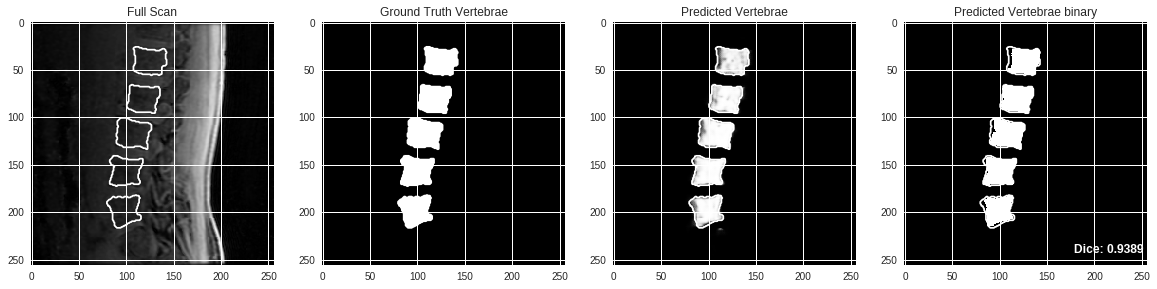

In [63]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t) #ix = 10
plt.savefig('training_preds.pdf', dpi=300)

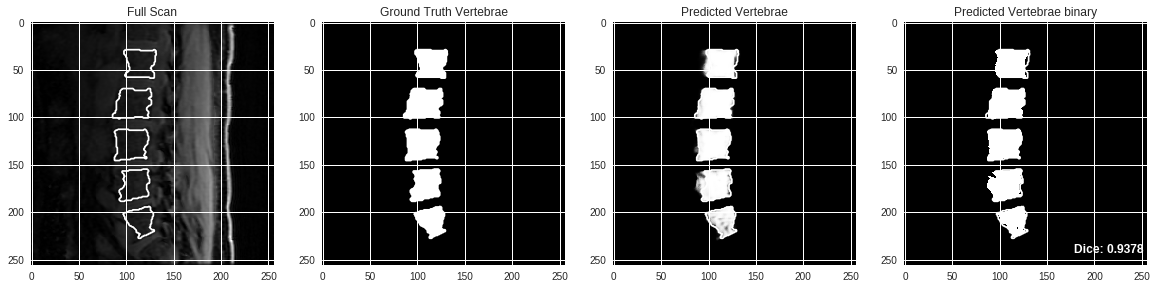

In [65]:
# Check if testing data looks all right
plot_sample(X_test, y_test, preds_test, preds_test_t) #ix = 10
plt.savefig('testing_preds.pdf', dpi=300)